In [21]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import wave

TensorFlow version: 2.6.0


In [22]:
import librosa
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout

import IPython.display as ipd

In [23]:
#importing  libraries
#Keras
import tensorflow.keras
from tensorflow.keras import regularizers, layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

#sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Others
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import tensorflow as tf
import pandas as pd
import seaborn as sns
import glob
import os
import pickle
import IPython.display as ipd
import csv
from tqdm import tqdm
import os


import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
#from include import helpers

from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
#split the dataset into train and test
X_train = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/X_train_chroma_stft.csv')
y_train = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/y_train_chroma_stft.csv')
X_test = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/X_test_chroma_stft.csv')
y_test = pd.read_csv('https://raw.githubusercontent.com/fatmaaerr/ML_Urbansound8k_project/main/Data/y_test_chroma_stft.csv')
#take a peak at the data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4499, 1), (4499, 1), (4233, 2), (4233, 2))

In [25]:
#One hot encode labels

le = LabelEncoder()

def encoding_y(data):
  data = np.array(data['label'])
  data = to_categorical(le.fit_transform(data))
  return data

y_train = encoding_y(y_train)
y_test = encoding_y(y_test) 

In [26]:
X_test = X_test.iloc[:,1:2]
#normalization (helps with exploding gradient); good as we are mixing a lot of datasets
def standardization(data):
  mean = np.mean(data,axis=0)
  std = np.std(data, axis=0)
  data =( data - mean)/std
  data = np.array(data)
  return data

X_train = standardization(X_train)
X_test = standardization(X_test)


In [27]:
model = Sequential()
model.add(layers.Dense(1000, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(750, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt_rmp = tensorflow.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1000)              2000      
_________________________________________________________________
dense_8 (Dense)              (None, 750)               750750    
_________________________________________________________________
dense_9 (Dense)              (None, 500)               375500    
_________________________________________________________________
dense_10 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_11 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_12 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [28]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1000)              2000      
_________________________________________________________________
dense_8 (Dense)              (None, 750)               750750    
_________________________________________________________________
dense_9 (Dense)              (None, 500)               375500    
_________________________________________________________________
dense_10 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_11 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_12 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4499, 1), (4233, 1), (4499, 10), (4233, 10))

In [30]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [31]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 100
num_batch_size = 32
checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
model_chroma_stft=model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
141/141 [==============================] - 6s 22ms/step - loss: 2.0574 - accuracy: 0.2078 - val_loss: 2.1440 - val_accuracy: 0.1743

Epoch 00001: val_loss improved from inf to 2.14405, saving model to .\audio_classification.hdf5
Epoch 2/100
141/141 [==============================] - 2s 16ms/step - loss: 1.9914 - accuracy: 0.2289 - val_loss: 2.0572 - val_accuracy: 0.2062

Epoch 00002: val_loss improved from 2.14405 to 2.05721, saving model to .\audio_classification.hdf5
Epoch 3/100
141/141 [==============================] - 2s 16ms/step - loss: 1.9762 - accuracy: 0.2285 - val_loss: 2.0656 - val_accuracy: 0.2001

Epoch 00003: val_loss did not improve from 2.05721
Epoch 4/100
141/141 [==============================] - 2s 16ms/step - loss: 1.9737 - accuracy: 0.2247 - val_loss: 2.0938 - val_accuracy: 0.1895

Epoch 00004: val_loss did not improve from 2.05721
Epoch 5/100
141/141 [==============================] - 2s 15ms/step - loss: 1.9633 - accuracy: 0.2358 - val_loss: 2.0516 -


Epoch 00041: val_loss did not improve from 2.05101
Epoch 42/100
141/141 [==============================] - 10s 71ms/step - loss: 1.9285 - accuracy: 0.2478 - val_loss: 2.0837 - val_accuracy: 0.2039

Epoch 00042: val_loss did not improve from 2.05101
Epoch 43/100
141/141 [==============================] - 9s 60ms/step - loss: 1.9293 - accuracy: 0.2556 - val_loss: 2.0675 - val_accuracy: 0.1982

Epoch 00043: val_loss did not improve from 2.05101
Epoch 44/100
141/141 [==============================] - 10s 71ms/step - loss: 1.9281 - accuracy: 0.2536 - val_loss: 2.0814 - val_accuracy: 0.2185

Epoch 00044: val_loss did not improve from 2.05101
Epoch 45/100
141/141 [==============================] - 9s 67ms/step - loss: 1.9271 - accuracy: 0.2494 - val_loss: 2.0818 - val_accuracy: 0.2039

Epoch 00045: val_loss did not improve from 2.05101
Epoch 46/100
141/141 [==============================] - 9s 63ms/step - loss: 1.9279 - accuracy: 0.2498 - val_loss: 2.0811 - val_accuracy: 0.2091

Epoch 00046:

141/141 [==============================] - 7s 52ms/step - loss: 1.9161 - accuracy: 0.2534 - val_loss: 2.0923 - val_accuracy: 0.2013

Epoch 00083: val_loss did not improve from 2.05101
Epoch 84/100
141/141 [==============================] - 5s 36ms/step - loss: 1.9173 - accuracy: 0.2527 - val_loss: 2.0927 - val_accuracy: 0.2077

Epoch 00084: val_loss did not improve from 2.05101
Epoch 85/100
141/141 [==============================] - 5s 39ms/step - loss: 1.9177 - accuracy: 0.2509 - val_loss: 2.0817 - val_accuracy: 0.2060

Epoch 00085: val_loss did not improve from 2.05101
Epoch 86/100
141/141 [==============================] - 6s 41ms/step - loss: 1.9163 - accuracy: 0.2574 - val_loss: 2.0884 - val_accuracy: 0.2069

Epoch 00086: val_loss did not improve from 2.05101
Epoch 87/100
141/141 [==============================] - 5s 34ms/step - loss: 1.9179 - accuracy: 0.2538 - val_loss: 2.0913 - val_accuracy: 0.2133

Epoch 00087: val_loss did not improve from 2.05101
Epoch 88/100
141/141 [======

In [32]:
# Evaluating the model on the training and testing set

score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.25916871428489685
Testing Accuracy:  0.2102527767419815


In [33]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.2102527767419815


In [34]:
#model.predict_classes(X_test)
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

[9 4 4 ... 3 3 3]


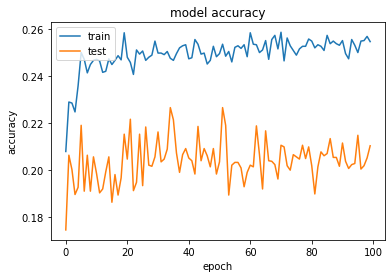

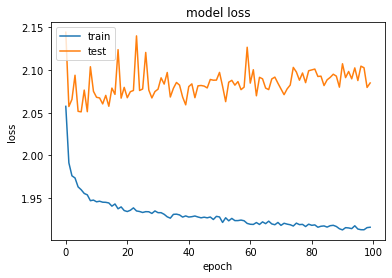

In [35]:
# summarize history for accuracy
plt.plot(model_chroma_stft.history['accuracy'])
plt.plot(model_chroma_stft.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_chroma_stft.history['loss'])
plt.plot(model_chroma_stft.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
#Avg Test accuracy and Standart Devision 

In [37]:
train_hist = pd.DataFrame(model_chroma_stft.history)
train_hist

,loss,accuracy,val_loss,val_accuracy
0,2.057405,0.207824,2.144046,0.174344
1,1.991441,0.228940,2.057209,0.206237
2,1.976245,0.228495,2.065555,0.200094
3,1.973713,0.224717,2.093782,0.189464
4,1.963306,0.235830,2.051606,0.192535
...,...,...,...,...
95,1.914024,0.250056,2.087579,0.214741
96,1.913244,0.254946,2.104394,0.200331
97,1.913184,0.255168,2.102535,0.201748
98,1.915686,0.256946,2.079545,0.205056


In [38]:
print(train_hist["val_accuracy"].describe())

count    100.000000
mean       0.203855
std        0.008920
min        0.174344
25%        0.199681
50%        0.203756
75%        0.207949
max        0.226553
Name: val_accuracy, dtype: float64


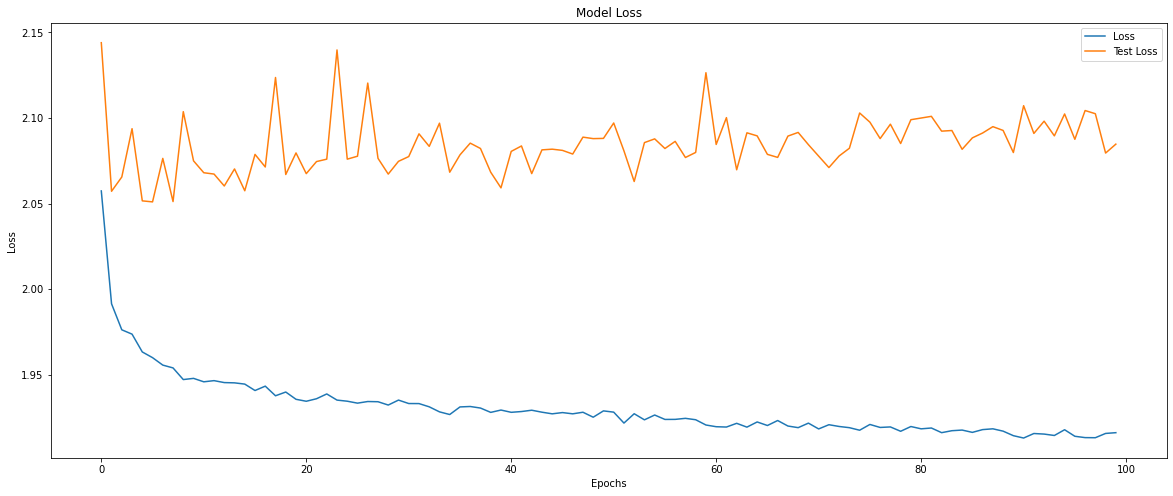

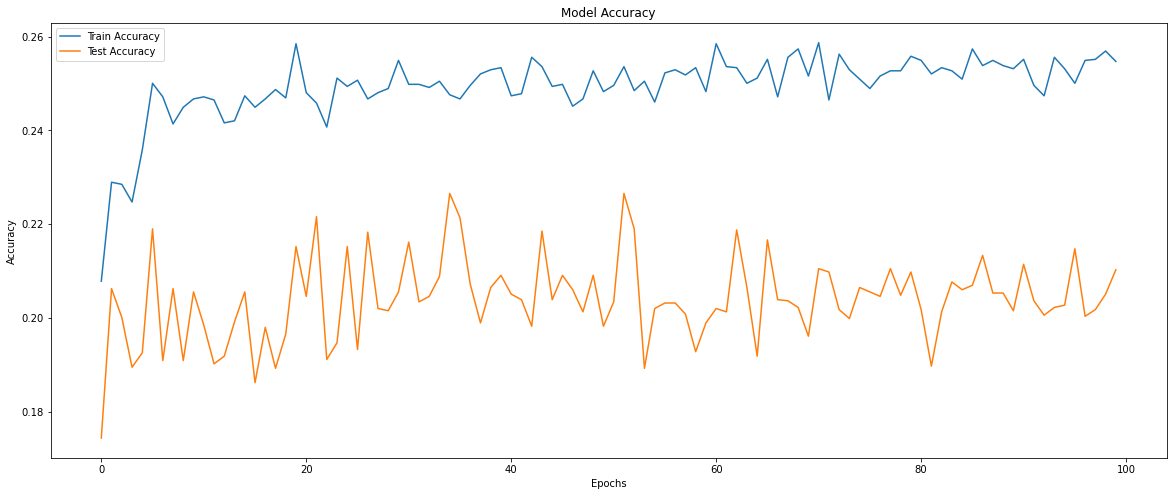

In [39]:
plt.figure(figsize=(20,8))
plt.plot(train_hist[['loss','val_loss']])
plt.legend(['Loss','Test Loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_hist[['accuracy','val_accuracy']])
plt.legend(['Train Accuracy','Test Accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [40]:
ytrue = np.argmax(y_test,axis=1)
ypred = np.argmax(model.predict(X_test),axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue,ypred))
print('\n\nClassification Report : \n\n',classification_report(ytrue,ypred))


Confusion Matrix :


[[123   0  27  77  64  24   2 133  47   3]
 [  3   0  11  52  12   0   0  12 117  14]
 [ 23   0  45 163  73   2   0 120  55  19]
 [ 16   0  43 155  66   0   0  87 106  27]
 [ 21   0  50  66  72  12   3 240  28   8]
 [ 48   0  18  86  67  14   8 216  18   8]
 [ 26   0   0   5   4  16  21 107   4   1]
 [ 40   0  30  40  66  21   5 231  16   3]
 [  8   0  19  78  42   2   0  30 199  15]
 [ 16   0  31 175  18   0   0  30 200  30]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.38      0.25      0.30       500
           1       0.00      0.00      0.00       221
           2       0.16      0.09      0.12       500
           3       0.17      0.31      0.22       500
           4       0.15      0.14      0.15       500
           5       0.15      0.03      0.05       483
           6       0.54      0.11      0.19       184
           7       0.19      0.51      0.28       452
           8       0.25      0.

C:\Users\fatma.er\Anaconda3\envs\Mylovelyproject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fatma.er\Anaconda3\envs\Mylovelyproject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fatma.er\Anaconda3\envs\Mylovelyproject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta